# 變數重要性

## 一、載入套件及資料集

In [75]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from util import get_dummies, detect_str_columns,model,profit_linechart,profit_linechart_all,logistic_model
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# ----設定繪圖-------
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px


In [76]:
# 讀取資料
data = pd.read_csv('contract.csv')
data.head(5)

,Prod_output_num,locations,gender,age,click_on_prod,balance,registry_to_use_time,credit_card_paid,active_member,estimated_salary,buy,UID
0,619,Taipei,Female,42,2,0.00,4,1,0,101348.88,1,0
1,608,Tainan,Female,41,1,83807.86,4,0,0,112542.58,0,1
2,502,Taipei,Female,42,8,159660.80,2,1,1,113931.57,1,2
3,699,Taipei,Female,39,1,0.00,3,0,1,93826.63,0,3
4,850,Tainan,Female,43,2,125510.82,4,1,0,79084.10,0,4


## 二、資料前處理

In [77]:
# 偵測有字串的欄位
str_columns = detect_str_columns(data)
dataset = get_dummies(str_columns, data)

# 切分資料集
X =dataset.drop(columns=['buy'])
y =dataset['buy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 
# 保留UID
train_uid = X_train['UID']
test_uid = X_test['UID']

# 設定xgb 分類模型
# 刪除UID
del X_train['UID']
del X_test['UID']

## 三、XGBClassifier重要性分析

In [78]:
xgb_model = XGBClassifier(n_estimators = 300, random_state = 0,nthread = 8)

In [79]:
# 訓練
model_xgb = xgb_model.fit(X_train, y_train, verbose=True,
                        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.54555	validation_1-logloss:0.54844
[1]	validation_0-logloss:0.46487	validation_1-logloss:0.46964
[2]	validation_0-logloss:0.41426	validation_1-logloss:0.42155
[3]	validation_0-logloss:0.38225	validation_1-logloss:0.39151
[4]	validation_0-logloss:0.35869	validation_1-logloss:0.37068
[5]	validation_0-logloss:0.34120	validation_1-logloss:0.35691
[6]	validation_0-logloss:0.32922	validation_1-logloss:0.34798
[7]	validation_0-logloss:0.31883	validation_1-logloss:0.34201
[8]	validation_0-logloss:0.31095	validation_1-logloss:0.33791
[9]	validation_0-logloss:0.30463	validation_1-logloss:0.33557
[10]	validation_0-logloss:0.30081	validation_1-logloss:0.33410
[11]	validation_0-logloss:0.29698	validation_1-logloss:0.33393
[12]	validation_0-logloss:0.29254	validation_1-logloss:0.33239
[13]	validation_0-logloss:0.28987	validation_1-logloss:0.33148
[14]	validation_0-logloss:0.28509	validation_1-logloss:0.33241
[15]	validation_0-logloss:0.28060	validation_1-logloss:0.33055
[1

### 抓出重要特徵值的重要性

In [80]:
# feature importances：變數重要性
feat_imp = model_xgb.feature_importances_
feat_imp.sum()

1.0

In [81]:
# 新增的Cell：查看importance裡面的樣子
feat_imp

array([0.04340016, 0.11266518, 0.0388808 , 0.05783476, 0.28120565,
       0.03560276, 0.15115465, 0.04365196, 0.10935609, 0.07045466,
       0.05579334], dtype=float32)

### 抓出特徵值欄位

In [82]:
feat = X_train.columns.tolist()
feat

['Prod_output_num',
 'age',
 'click_on_prod',
 'balance',
 'registry_to_use_time',
 'credit_card_paid',
 'active_member',
 'estimated_salary',
 'locations_Tainan',
 'locations_Taipei',
 'gender_Male']

### 合併變成DataFrame 

In [83]:
res_data = pd.DataFrame({'特徵值': feat,
                        '重要性程度': feat_imp})
res_data = res_data.sort_values('重要性程度',ascending=True)
res_data

,特徵值,重要性程度
5,credit_card_paid,0.035603
2,click_on_prod,0.038881
0,Prod_output_num,0.043400
7,estimated_salary,0.043652
10,gender_Male,0.055793
3,balance,0.057835
9,locations_Taipei,0.070455
8,locations_Tainan,0.109356
1,age,0.112665
6,active_member,0.151155


In [84]:
### 視覺化
# bar：barchart代表長條圖
plot_name = 'xgb_Importances'
fig = px.bar(res_data, x='重要性程度', y='特徵值',
            color='重要性程度',orientation='h' )
plot(fig, filename = plot_name+ '.html')

'xgb_Importances.html'

In [85]:
fig

In [86]:
# 根據「重要性程度」，由高至低排序
res_data = res_data.sort_values('重要性程度', ascending= False)
res_data

,特徵值,重要性程度
4,registry_to_use_time,0.281206
6,active_member,0.151155
1,age,0.112665
8,locations_Tainan,0.109356
9,locations_Taipei,0.070455
3,balance,0.057835
10,gender_Male,0.055793
7,estimated_salary,0.043652
0,Prod_output_num,0.043400
2,click_on_prod,0.038881


## 四、RandomForestClassifier重要性分析

In [87]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0,verbose=1,n_jobs=8)

In [88]:
rf_model.fit( X_train , y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=8, random_state=0, verbose=1)

In [89]:
# 抓出重要特徵值
feat_imp = rf_model.feature_importances_
feat_imp

array([0.14643352, 0.2389462 , 0.0825038 , 0.14161117, 0.12826434,
       0.01918327, 0.03690052, 0.14953559, 0.01768844, 0.02016647,
       0.01876669])

In [90]:
# 抓出特徵值欄位
feat = X_train.columns.tolist()
feat

['Prod_output_num',
 'age',
 'click_on_prod',
 'balance',
 'registry_to_use_time',
 'credit_card_paid',
 'active_member',
 'estimated_salary',
 'locations_Tainan',
 'locations_Taipei',
 'gender_Male']

In [91]:
res_data = pd.DataFrame({'特徵值': feat,
                        '重要性程度': feat_imp})
res_data

,特徵值,重要性程度
0,Prod_output_num,0.146434
1,age,0.238946
2,click_on_prod,0.082504
3,balance,0.141611
4,registry_to_use_time,0.128264
5,credit_card_paid,0.019183
6,active_member,0.036901
7,estimated_salary,0.149536
8,locations_Tainan,0.017688
9,locations_Taipei,0.020166


In [92]:
# 繪圖的時候，必須要從低至高排序
res_data = res_data.sort_values('重要性程度', ascending=True)
# 視覺化
plot_name = 'rf_Importances'
fig = px.bar(res_data, x='重要性程度', y='特徵值',
            color='重要性程度',orientation='h' )
plot(fig, filename = plot_name+ '.html')

'rf_Importances.html'

In [93]:
fig

In [94]:
# 根據「重要性程度」，由高至低排序
res_data = res_data.sort_values(by='重要性程度', ascending=False)
res_data

,特徵值,重要性程度
1,age,0.238946
7,estimated_salary,0.149536
0,Prod_output_num,0.146434
3,balance,0.141611
4,registry_to_use_time,0.128264
2,click_on_prod,0.082504
6,active_member,0.036901
9,locations_Taipei,0.020166
5,credit_card_paid,0.019183
10,gender_Male,0.018767


## 五、羅吉斯回歸重要性分析


In [95]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()

In [96]:
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [97]:
# coef_: 係數，找出每一個欄位/變數的方向性
logistic_reg.coef_

array([[-5.00656203e-03,  4.38844446e-02, -2.26874845e-03,
         3.57078406e-06, -4.60233964e-04, -2.21335061e-04,
         1.18869212e-03, -1.43598386e-06, -2.68098279e-04,
        -8.91596050e-04, -1.04454902e-03]])

In [98]:
feat_imp = logistic_reg.coef_.tolist()[0]
feat_imp

[-0.0050065620309645495,
 0.04388444460695675,
 -0.002268748453626324,
 3.570784058131269e-06,
 -0.00046023396396059846,
 -0.00022133506131396456,
 0.0011886921207504893,
 -1.4359838633839826e-06,
 -0.0002680982787305532,
 -0.0008915960501870627,
 -0.0010445490200863723]

In [99]:
X_train.columns

Index(['Prod_output_num', 'age', 'click_on_prod', 'balance',
       'registry_to_use_time', 'credit_card_paid', 'active_member',
       'estimated_salary', 'locations_Tainan', 'locations_Taipei',
       'gender_Male'],
      dtype='object')

In [100]:
feat = X_train.columns.tolist()
feat

['Prod_output_num',
 'age',
 'click_on_prod',
 'balance',
 'registry_to_use_time',
 'credit_card_paid',
 'active_member',
 'estimated_salary',
 'locations_Tainan',
 'locations_Taipei',
 'gender_Male']

In [101]:
res_data_logistic = pd.DataFrame({'特徵值': feat, '重要性程度': feat_imp})
res_data_logistic

,特徵值,重要性程度
0,Prod_output_num,-0.005007
1,age,0.043884
2,click_on_prod,-0.002269
3,balance,0.000004
4,registry_to_use_time,-0.000460
5,credit_card_paid,-0.000221
6,active_member,0.001189
7,estimated_salary,-0.000001
8,locations_Tainan,-0.000268
9,locations_Taipei,-0.000892


In [102]:
res_data_logistic = res_data_logistic.sort_values(by='重要性程度', ascending=False)
res_data_logistic

,特徵值,重要性程度
1,age,0.043884
6,active_member,0.001189
3,balance,0.000004
7,estimated_salary,-0.000001
5,credit_card_paid,-0.000221
8,locations_Tainan,-0.000268
4,registry_to_use_time,-0.000460
9,locations_Taipei,-0.000892
10,gender_Male,-0.001045
2,click_on_prod,-0.002269


### 單位增/減量

In [103]:
# exponential 與 log互相呈現反函數
# 兩者可以互相被轉換回來
np.exp(np.log(2))

2.0

In [104]:
# logistic regression裡面的係數/重要性程度是經過log轉換的哦！
# 若要將係數轉換回來，要取exponential function
# 會變成倍數，舉例：1.3，代表1.3倍的意思
# 若1.3 - 1 = 30%，言下之意即是增加30%
# 實踐：exp(x) - 1
res_data_logistic['對y值的影響百分比'] = np.exp(res_data_logistic['重要性程度']) -1

In [105]:
res_data_logistic

,特徵值,重要性程度,對y值的影響百分比
1,age,0.043884,0.044862
6,active_member,0.001189,0.001189
3,balance,0.000004,0.000004
7,estimated_salary,-0.000001,-0.000001
5,credit_card_paid,-0.000221,-0.000221
8,locations_Tainan,-0.000268,-0.000268
4,registry_to_use_time,-0.000460,-0.000460
9,locations_Taipei,-0.000892,-0.000891
10,gender_Male,-0.001045,-0.001044
2,click_on_prod,-0.002269,-0.002266


### 視覺化

In [106]:
# 根據Importance，由低至高排序
# 因爲：繪圖的時候，必須要從低至高排序
res_data_logistic = res_data_logistic.sort_values(by='對y值的影響百分比', ascending=True)

# 視覺化重要性
plot_name = 'lr_Importances'
fig = px.bar(res_data_logistic, x='對y值的影響百分比', y='特徵值',
            color='對y值的影響百分比',orientation='h' )
plot(fig, filename = plot_name+ '.html')

'lr_Importances.html'

In [107]:
fig

In [108]:
# 根據Importance，由低至高排序
res_data_logistic = res_data_logistic.sort_values(by='對y值的影響百分比', ascending=False)
res_data_logistic

,特徵值,重要性程度,對y值的影響百分比
1,age,0.043884,0.044862
6,active_member,0.001189,0.001189
3,balance,0.000004,0.000004
7,estimated_salary,-0.000001,-0.000001
5,credit_card_paid,-0.000221,-0.000221
8,locations_Tainan,-0.000268,-0.000268
4,registry_to_use_time,-0.000460,-0.000460
9,locations_Taipei,-0.000892,-0.000891
10,gender_Male,-0.001045,-0.001044
2,click_on_prod,-0.002269,-0.002266


## 六、將Random Forest產出的重要性分析（res_data）與邏輯斯迴歸產出的重要性分析（res_data_logistic）結合在一起

In [109]:
res_data

,特徵值,重要性程度
1,age,0.238946
7,estimated_salary,0.149536
0,Prod_output_num,0.146434
3,balance,0.141611
4,registry_to_use_time,0.128264
2,click_on_prod,0.082504
6,active_member,0.036901
9,locations_Taipei,0.020166
5,credit_card_paid,0.019183
10,gender_Male,0.018767


In [110]:
del res_data_logistic['重要性程度']
res_data_logistic

,特徵值,對y值的影響百分比
1,age,0.044862
6,active_member,0.001189
3,balance,0.000004
7,estimated_salary,-0.000001
5,credit_card_paid,-0.000221
8,locations_Tainan,-0.000268
4,registry_to_use_time,-0.000460
9,locations_Taipei,-0.000891
10,gender_Male,-0.001044
2,click_on_prod,-0.002266


In [111]:
res_data = res_data.sort_values('特徵值')
res_data_logistic = res_data_logistic.sort_values('特徵值')
imp_table = pd.concat([ res_data, res_data_logistic['對y值的影響百分比'] ], axis =  1)
imp_table = imp_table.sort_values('重要性程度', ascending=False)
# 在此的「重要性程度」是誰的孩子？
# 是「隨機森林」的「重要性程度」，非「邏輯斯迴歸」的哦！
# 「邏輯斯迴歸」貢獻的是「對y值的影響百分比」
imp_table
# 對y值的影響百分比 for age？
# 當我消費者裡面的age，每增加1單位（歲），會增加約4.5%的購買機率
# 所以可以簡易得知，年齡越高，對我來說越有利
# 多高？ 看決策樹： active member且50.5歲

,特徵值,重要性程度,對y值的影響百分比
1,age,0.238946,0.044862
7,estimated_salary,0.149536,-0.000001
0,Prod_output_num,0.146434,-0.004994
3,balance,0.141611,0.000004
4,registry_to_use_time,0.128264,-0.000460
2,click_on_prod,0.082504,-0.002266
6,active_member,0.036901,0.001189
9,locations_Taipei,0.020166,-0.000891
5,credit_card_paid,0.019183,-0.000221
10,gender_Male,0.018767,-0.001044


In [112]:
#使用np.where將「對y值的影響百分比」<0的特徵值額外標示為「負向調整」，否則為「正向調整」
# np.where如同Excel裡面的if else函數
imp_table['調整方向'] = np.where( imp_table['對y值的影響百分比']<0, '負向調整', '正向調整')
imp_table.columns = ['特徵值', '重要性分數(優先排序)', '對y值的影響百分比（方向性）',  '調整方向']
imp_table


,特徵值,重要性分數(優先排序),對y值的影響百分比（方向性）,調整方向
1,age,0.238946,0.044862,正向調整
7,estimated_salary,0.149536,-0.000001,負向調整
0,Prod_output_num,0.146434,-0.004994,負向調整
3,balance,0.141611,0.000004,正向調整
4,registry_to_use_time,0.128264,-0.000460,負向調整
2,click_on_prod,0.082504,-0.002266,負向調整
6,active_member,0.036901,0.001189,正向調整
9,locations_Taipei,0.020166,-0.000891,負向調整
5,credit_card_paid,0.019183,-0.000221,負向調整
10,gender_Male,0.018767,-0.001044,負向調整


## 六、用決策樹解釋商業意涵

In [114]:
from sklearn.tree import DecisionTreeClassifier

# 修剪枝節(pruning)：
# max_depth：深度，由上至下的最大延展程度
# max_leaf_nodes：廣度，由左至右的最大延展程度
# max_depth=5, max_leaf_nodes= 7
decision_reg = DecisionTreeClassifier(max_depth=5, max_leaf_nodes= 7)
# decision_reg = DecisionTreeClassifier()

In [115]:
decision_reg.fit(X_train, y_train)
y_pred = decision_reg.predict(X_test)

In [116]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.842


### 畫出決策樹

In [117]:
from sklearn import tree
import graphviz
import os
import platform

if platform.system() ==  'Windows':
    os.environ["PATH"] += os.pathsep + 'C:\\Users\\saman\\Graphviz\\bin'

dot_data = tree.export_graphviz(decision_reg, out_file=None,
                    feature_names=X_test.columns,
                    class_names=['no','yes'],
                    filled=True, rounded=True,
                    special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('marketing')

'marketing.pdf'

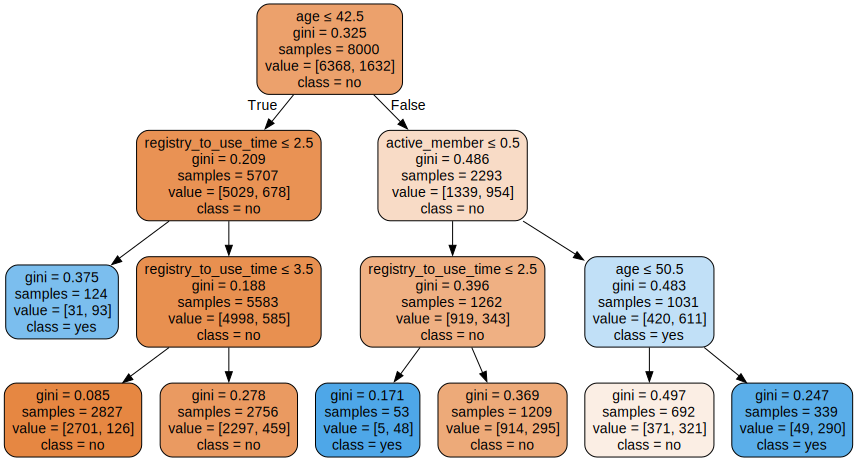

In [118]:
graph

### 使用最適參數的決策樹方法

In [119]:
# 測試從2 ~ 10的深、廣度對準確度的影響，若越准，則採用該參數
save = [] # 用save這個list來存每一次的測試結果
for para in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:

    from sklearn.tree import DecisionTreeClassifier

    # 修剪枝節(pruning)：
    # max_depth：深度，由上至下的最大延展程度
    # max_leaf_nodes：廣度，由左至右的最大延展程度
    # max_depth=5, max_leaf_nodes= 7
    decision_reg = DecisionTreeClassifier(max_depth=para, max_leaf_nodes= para)

    decision_reg.fit(X_train, y_train)

    # 如何決定潛在最適的深、廣度？（參數）
    # 可能的解答：藉由預測X_test來查看最好的KPI/財務/準確度
    y_pred = decision_reg.predict(X_test)

    # 載入準確度套件
    # 本次以準確度為例
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_test, y_pred)
    print(acc)

    # 存測試結果:參數與準確度，共兩種結果
    save.append([para, acc])

0.7975
0.8285
0.8365
0.8335
0.842
0.842
0.842
0.8545
0.8605
0.8605
0.8605
0.861
0.861
0.8585
0.8585
0.8585
0.8595


In [121]:
# 將save轉換成data frame，便於排序與檢視
save = pd.DataFrame(save)
save.columns = ['參數', '準確度']
# 準確度由高至低排序
save = save.sort_values('準確度', ascending=False)
save

,參數,準確度
12,14,0.8610
11,13,0.8610
8,10,0.8605
9,11,0.8605
10,12,0.8605
16,18,0.8595
13,15,0.8585
14,16,0.8585
15,17,0.8585
7,9,0.8545


In [122]:
from sklearn.tree import DecisionTreeClassifier

# 修剪枝節(pruning)：
# max_depth：深度，由上至下的最大延展程度
# max_leaf_nodes：廣度，由左至右的最大延展程度
# max_depth=5, max_leaf_nodes= 7
ecision_reg = DecisionTreeClassifier(max_depth = save['參數'].iloc[0], max_leaf_nodes= save['參數'].iloc[0])
ecision_reg.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=14, max_leaf_nodes=14)

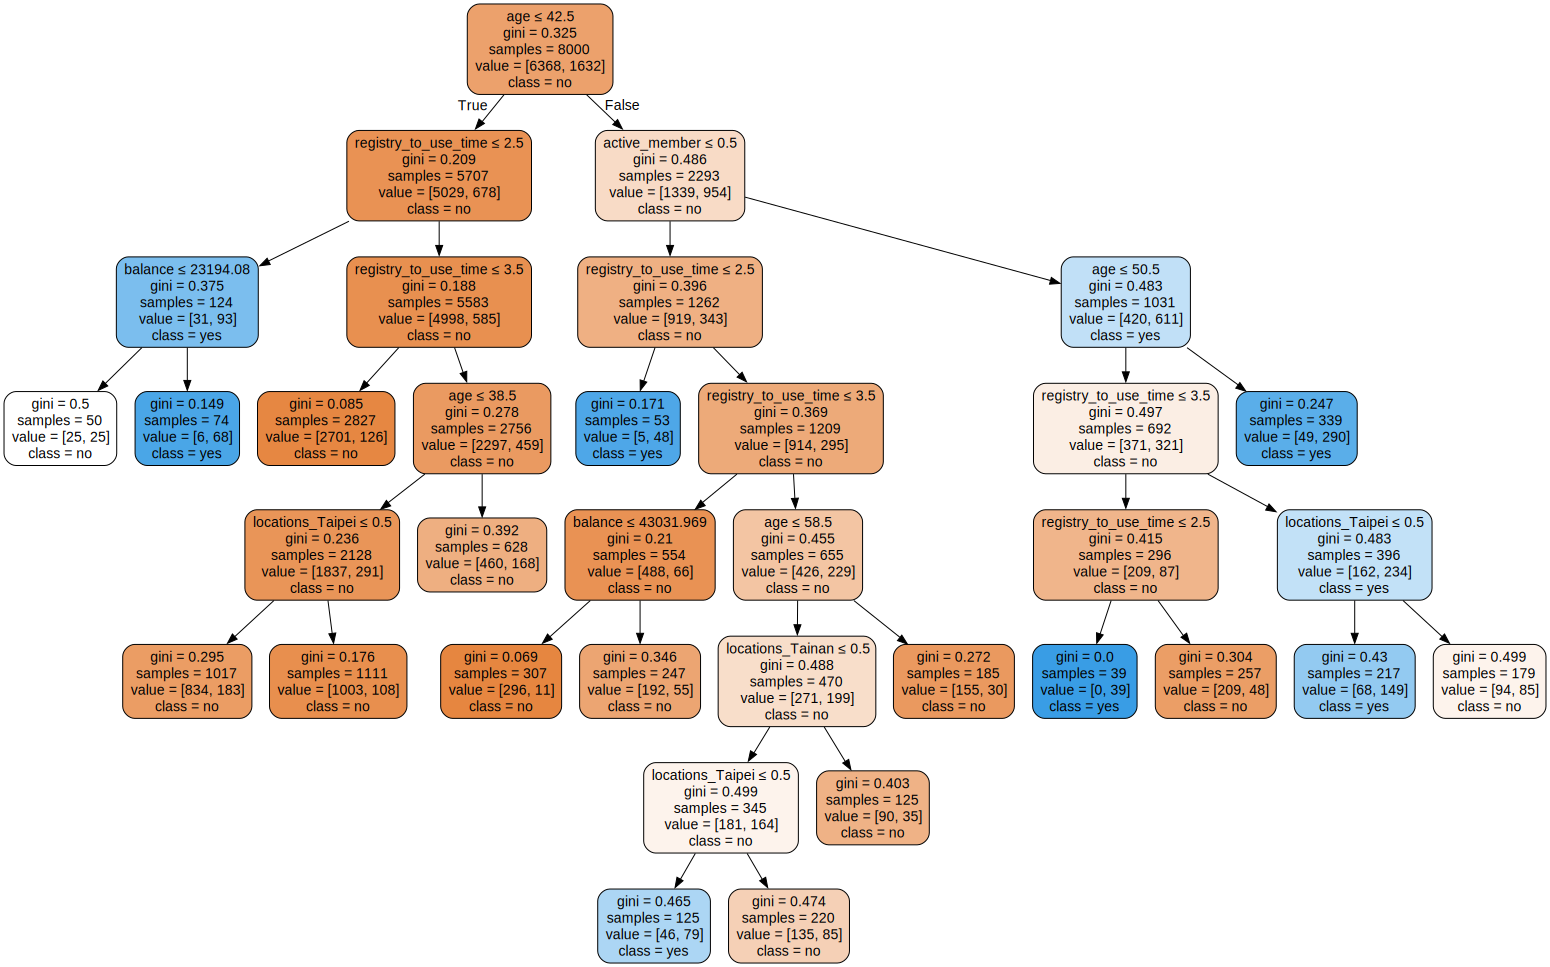

In [123]:
if platform.system() ==  'Windows':
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(decision_reg, out_file=None,
                    feature_names=X_test.columns,
                    class_names=['no','yes'],
                    filled=True, rounded=True,
                    special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('marketing_optimizetree')
graph